<a href="https://colab.research.google.com/github/imvinit/DNN/blob/main/PA3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load MNIST data

In [ ]:
# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 93805049.58it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75146212.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29139541.65it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9430954.84it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**MNIST classification using RNN**

Split data

In [ ]:
# Split data into training, validation, and test sets
train_size = 50000
val_size = 10000
test_size = 10000

train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RNN Model

In [ ]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layer):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layer, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


LSTM Model

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layer):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

Bidirectional LSTM

In [ ]:
# Define the Bidirectional LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layer):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

Training

In [ ]:
# Training function
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.view(-1, 28, 28).to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.view(-1, 28, 28).to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        accuracy = correct / total
        accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {average_train_loss:.4f}, "
              f"Validation Loss: {average_val_loss:.4f}, "
              f"Accuracy: {accuracy:.4f}")

    return train_losses, val_losses, accuracies

Test function

In [ ]:
# Testing function
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.view(-1, 28, 28).to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    return accuracy

In [ ]:
import time

def elapsed_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Parameter experiment number 1

In [ ]:
# Train and test the models with different parameters
input_size = 28
output_size = 10
num_epochs = 10
num_layer = 2
lr = 0.001
hidden_size_rnn = 16

# Vanilla RNN
rnn_model = RNNModel(input_size, hidden_size_rnn, output_size, num_layer).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=lr)
start_time = time.time()
rnn_train_losses, rnn_val_losses, rnn_accuracies = train(rnn_model, criterion, optimizer_rnn, train_loader, val_loader, num_epochs)
end_time = time.time()
print(f"Elapsed time {elapsed_time(start_time, end_time)}")
pytorch_total_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
print(f"Total number of params: {pytorch_total_params}")
rnn_test_accuracy = test(rnn_model, test_loader)

Epoch [1/10], Train Loss: 1.5378, Validation Loss: 1.1220, Accuracy: 0.5987
Epoch [2/10], Train Loss: 0.9709, Validation Loss: 0.8434, Accuracy: 0.7232
Epoch [3/10], Train Loss: 0.7176, Validation Loss: 0.6464, Accuracy: 0.7920
Epoch [4/10], Train Loss: 0.5666, Validation Loss: 0.5353, Accuracy: 0.8310
Epoch [5/10], Train Loss: 0.4782, Validation Loss: 0.4523, Accuracy: 0.8627
Epoch [6/10], Train Loss: 0.4247, Validation Loss: 0.4368, Accuracy: 0.8671
Epoch [7/10], Train Loss: 0.3908, Validation Loss: 0.4202, Accuracy: 0.8692
Epoch [8/10], Train Loss: 0.3706, Validation Loss: 0.4085, Accuracy: 0.8795
Epoch [9/10], Train Loss: 0.3511, Validation Loss: 0.3563, Accuracy: 0.8948
Epoch [10/10], Train Loss: 0.3331, Validation Loss: 0.3308, Accuracy: 0.9058
Elapsed time (5, 1)
Total number of params: 1450
Test Accuracy: 0.9129


Parameter experiment number 2

In [ ]:
# Train and test the models
input_size = 28
output_size = 10
num_epochs = 10
num_layer = 1
lr = 0.001
hidden_size_rnn = 128

# Vanilla RNN
rnn_model = RNNModel(input_size, hidden_size_rnn, output_size, num_layer).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=lr)
start_time = time.time()
rnn_train_losses, rnn_val_losses, rnn_accuracies = train(rnn_model, criterion, optimizer_rnn, train_loader, val_loader, num_epochs)
end_time = time.time()
print(f"Elapsed time {elapsed_time(start_time, end_time)}")
pytorch_total_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
print(f"Total number of params: {pytorch_total_params}")
rnn_test_accuracy = test(rnn_model, test_loader)

Epoch [1/10], Train Loss: 0.8144, Validation Loss: 0.4961, Accuracy: 0.8502
Epoch [2/10], Train Loss: 0.3818, Validation Loss: 0.2681, Accuracy: 0.9274
Epoch [3/10], Train Loss: 0.2548, Validation Loss: 0.2465, Accuracy: 0.9377
Epoch [4/10], Train Loss: 0.2130, Validation Loss: 0.2508, Accuracy: 0.9314
Epoch [5/10], Train Loss: 0.1845, Validation Loss: 0.1714, Accuracy: 0.9524
Epoch [6/10], Train Loss: 0.1743, Validation Loss: 0.1795, Accuracy: 0.9503
Epoch [7/10], Train Loss: 0.1539, Validation Loss: 0.1847, Accuracy: 0.9474
Epoch [8/10], Train Loss: 0.1468, Validation Loss: 0.1697, Accuracy: 0.9537
Epoch [9/10], Train Loss: 0.1389, Validation Loss: 0.1523, Accuracy: 0.9584
Epoch [10/10], Train Loss: 0.1274, Validation Loss: 0.1535, Accuracy: 0.9582
Elapsed time (5, 41)
Total number of params: 21514
Test Accuracy: 0.9581


Here, number of hidden layer and number of nurons 128, 1 gives acceptable accuracy with training of 2min30 sec. Similar result is also found:
num_layer = 4
hidden_size_rnn = 32


In [ ]:
# LSTM
input_size = 28
output_size = 10
num_epochs = 10
num_layer = 1
lr = 0.001
hidden_size_lstm = 128

lstm_model = LSTMModel(input_size, hidden_size_lstm, output_size, num_layer).to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=lr)
start_time = time.time()
lstm_train_losses, lstm_val_losses, lstm_accuracies = train(lstm_model, criterion, optimizer_lstm, train_loader, val_loader, num_epochs)
end_time = time.time()
print(f"Elapsed time {elapsed_time(start_time, end_time)}")
pytorch_total_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
print(f"Total number of params: {pytorch_total_params}")
lstm_test_accuracy = test(lstm_model, test_loader)

Epoch [1/10], Train Loss: 0.4822, Validation Loss: 0.1838, Accuracy: 0.9440
Epoch [2/10], Train Loss: 0.1349, Validation Loss: 0.1039, Accuracy: 0.9685
Epoch [3/10], Train Loss: 0.0927, Validation Loss: 0.1066, Accuracy: 0.9684
Epoch [4/10], Train Loss: 0.0728, Validation Loss: 0.0748, Accuracy: 0.9770
Epoch [5/10], Train Loss: 0.0603, Validation Loss: 0.0684, Accuracy: 0.9778
Epoch [6/10], Train Loss: 0.0506, Validation Loss: 0.0640, Accuracy: 0.9802
Epoch [7/10], Train Loss: 0.0467, Validation Loss: 0.0550, Accuracy: 0.9826
Epoch [8/10], Train Loss: 0.0388, Validation Loss: 0.0643, Accuracy: 0.9815
Epoch [9/10], Train Loss: 0.0352, Validation Loss: 0.0614, Accuracy: 0.9812
Epoch [10/10], Train Loss: 0.0306, Validation Loss: 0.0456, Accuracy: 0.9860
Elapsed time (8, 49)
Total number of params: 21514
Test Accuracy: 0.9818


In [ ]:
# BiLSTM
nput_size = 28
output_size = 10
num_epochs = 10
num_layer = 1
lr = 0.001
hidden_size_bilstm = 128
bilstm_model = BiLSTMModel(input_size, hidden_size_bilstm, output_size, num_layer).to(device)
optimizer_bilstm = optim.Adam(bilstm_model.parameters(), lr=lr)
start_time = time.time()
bilstm_train_losses, bilstm_val_losses, bilstm_accuracies = train(bilstm_model, criterion, optimizer_bilstm, train_loader, val_loader, num_epochs)
end_time = time.time()
print(f"Elapsed time {elapsed_time(start_time, end_time)}")
pytorch_total_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
print(f"Total number of params: {pytorch_total_params}")
bilstm_test_accuracy = test(bilstm_model, test_loader)

Epoch [1/10], Train Loss: 0.4785, Validation Loss: 0.1560, Accuracy: 0.9546
Epoch [2/10], Train Loss: 0.1345, Validation Loss: 0.1072, Accuracy: 0.9678
Epoch [3/10], Train Loss: 0.0920, Validation Loss: 0.0857, Accuracy: 0.9751
Epoch [4/10], Train Loss: 0.0754, Validation Loss: 0.0789, Accuracy: 0.9762
Epoch [5/10], Train Loss: 0.0591, Validation Loss: 0.0678, Accuracy: 0.9811
Epoch [6/10], Train Loss: 0.0510, Validation Loss: 0.0630, Accuracy: 0.9816
Epoch [7/10], Train Loss: 0.0449, Validation Loss: 0.1015, Accuracy: 0.9702
Epoch [8/10], Train Loss: 0.0402, Validation Loss: 0.0452, Accuracy: 0.9862
Epoch [9/10], Train Loss: 0.0352, Validation Loss: 0.0569, Accuracy: 0.9825
Epoch [10/10], Train Loss: 0.0325, Validation Loss: 0.0576, Accuracy: 0.9838
Elapsed time (14, 5)
Total number of params: 21514
Test Accuracy: 0.9810


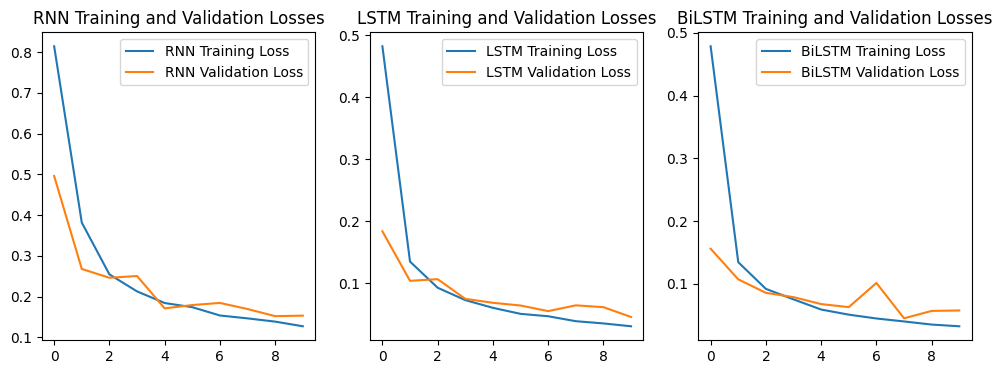

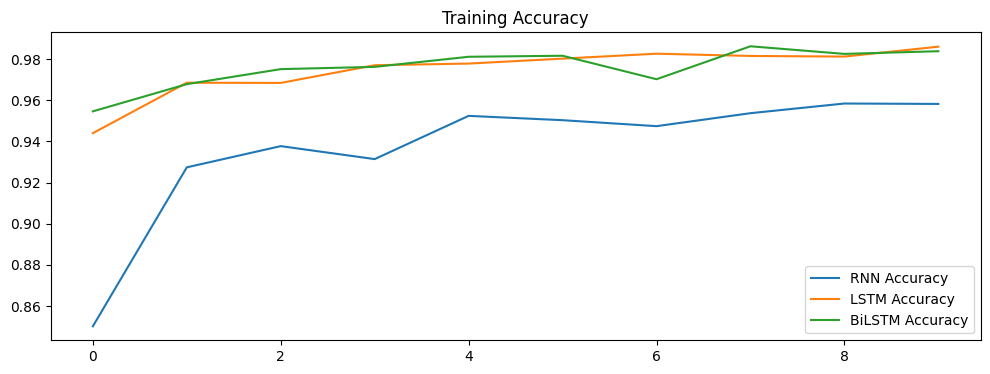

Vanilla RNN Test Accuracy: 0.9581
LSTM Test Accuracy: 0.9818
BiLSTM Test Accuracy: 0.9810


In [ ]:
# Plot training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(rnn_train_losses, label='RNN Training Loss')
plt.plot(rnn_val_losses, label='RNN Validation Loss')
plt.title('RNN Training and Validation Losses')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(lstm_train_losses, label='LSTM Training Loss')
plt.plot(lstm_val_losses, label='LSTM Validation Loss')
plt.title('LSTM Training and Validation Losses')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(bilstm_train_losses, label='BiLSTM Training Loss')
plt.plot(bilstm_val_losses, label='BiLSTM Validation Loss')
plt.title('BiLSTM Training and Validation Losses')
plt.legend()

plt.show()

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.plot(rnn_accuracies, label='RNN Accuracy')
plt.plot(lstm_accuracies, label='LSTM Accuracy')
plt.plot(bilstm_accuracies, label='BiLSTM Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Display test accuracies
print(f"Vanilla RNN Test Accuracy: {rnn_test_accuracy:.4f}")
print(f"LSTM Test Accuracy: {lstm_test_accuracy:.4f}")
print(f"BiLSTM Test Accuracy: {bilstm_test_accuracy:.4f}")

Prediction with handwritten data

Predicted Labels: [1 2 3 4 5 8 9 8 9 0]


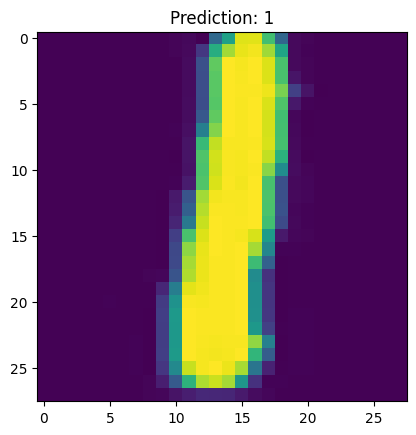

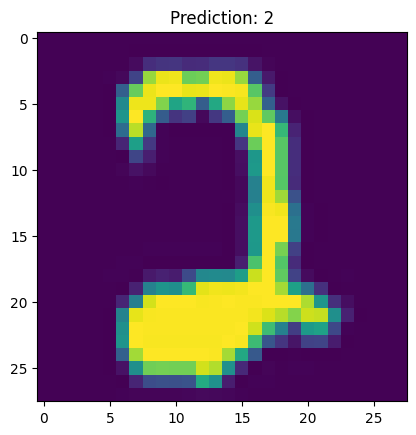

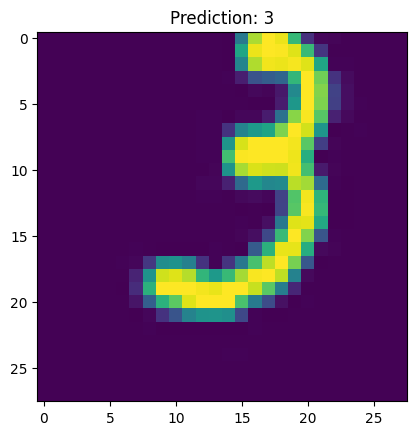

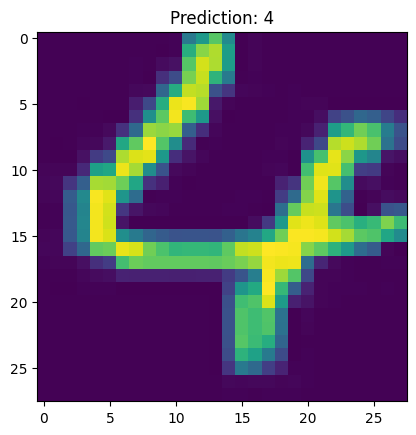

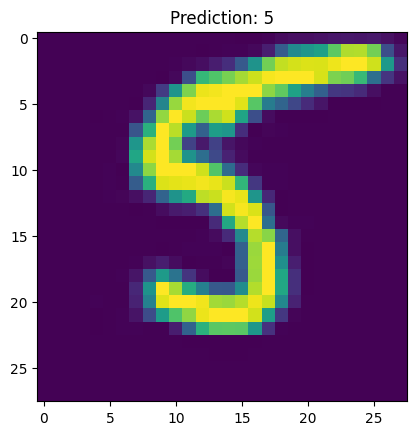

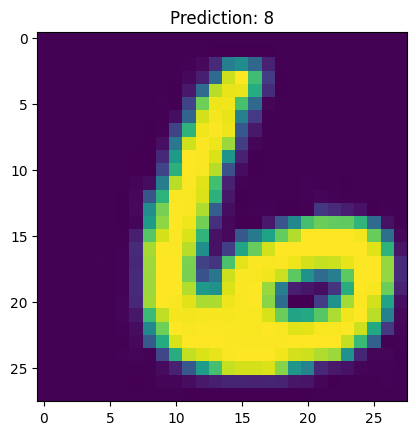

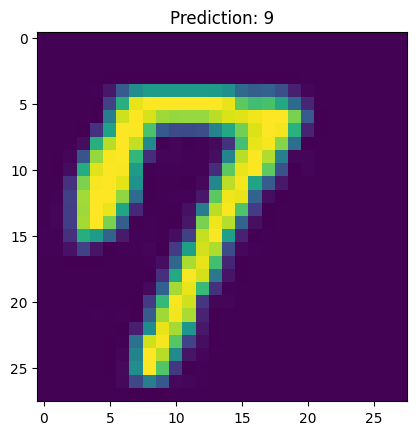

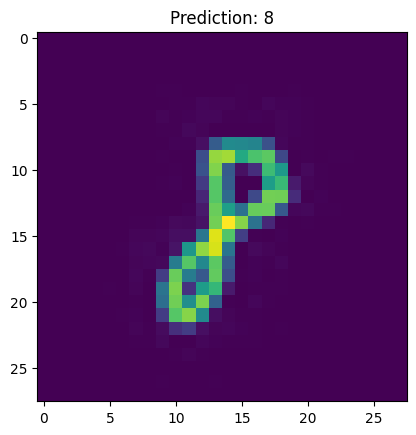

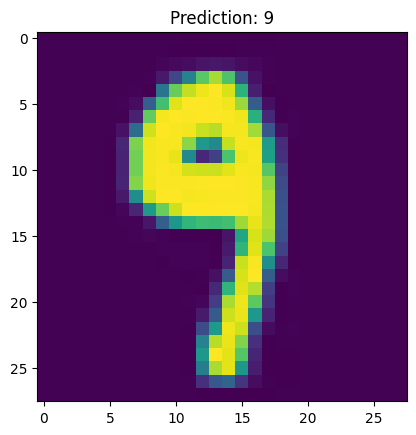

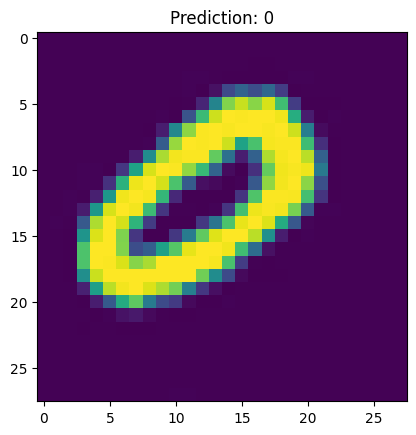

In [ ]:
import numpy as np
from PIL import Image, ImageOps
def load_custom_images(image_paths):
    custom_data = []
    transform = transforms.Compose([
        transforms.Resize((28, 28), transforms.InterpolationMode("bicubic")),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    for path in image_paths:
        img = Image.open(path).convert('L')
        img = ImageOps.invert(img)
        img = transform(img)
        custom_data.append(img)

    custom_data = torch.stack(custom_data)
    return custom_data

# Example usage of loading custom images and making predictions using the best model (choose the best model based on test accuracy)
custom_image_paths = ['/content/drive/MyDrive/1.jpeg', '/content/drive/MyDrive/2.jpeg',
                      '/content/drive/MyDrive/3.jpeg', '/content/drive/MyDrive/4.jpeg',
                      '/content/drive/MyDrive/5.jpeg', '/content/drive/MyDrive/6.jpeg',
                      '/content/drive/MyDrive/7.jpeg', '/content/drive/MyDrive/8.jpeg',
                      '/content/drive/MyDrive/9.jpeg', '/content/drive/MyDrive/0.jpeg']
custom_images = load_custom_images(custom_image_paths)
custom_images = custom_images.to(device)

# Make predictions using the best model (e.g., bidirectional LSTM)
model = bilstm_model
model.eval()
with torch.no_grad():
    predictions = model(custom_images.view(-1, 28, 28))
    predicted_labels = torch.argmax(predictions.data, 1)

# Print predicted labels
print("Predicted Labels:", predicted_labels.cpu().numpy())
for i in range(len(predicted_labels)):
    img_array = custom_images[i].squeeze().numpy()
    plt.imshow(img_array)
    plt.title(f"Prediction: {predicted_labels[i]}")
    plt.show()

**Adding two binary strings**

Data preparation

In [40]:
def generator(L):
    r1=np.random.randint(0,2**(L-1))
    r2=np.random.randint(0,2**(L-1))
    S=r1+r2
    binlen=L
    B1=np.zeros((1,binlen))
    B2=np.zeros((1,binlen))
    B3=np.zeros((binlen))
    b=np.flip(np.array(list(np.binary_repr(r1)), dtype=int))
    B1[0][0:len(b)]=b[0:]
    b=np.flip(np.array(list(np.binary_repr(r2)), dtype=int))
    B2[0][0:len(b)]=b[0:]
    b=np.flip(np.array(list(np.binary_repr(S)), dtype=int))
    B3[0:len(b)]=b[0:]
    return(np.concatenate((np.transpose(B1),np.transpose(B2)),axis=1),B3)


def generate_data(size,l=3):
    data=[]
    target=[]
    for i in range(size):
        a,b=generator(l)
        data.append(a)
        target.append(b)
    return data,target


generate_data(1,8)

([array([[1., 1.],
         [0., 1.],
         [1., 1.],
         [0., 0.],
         [1., 1.],
         [0., 1.],
         [0., 1.],
         [0., 0.]])],
 [array([0., 0., 1., 1., 0., 0., 0., 1.])])

In [41]:
class LSTM(nn.Module):

    def __init__(self,hidsize):
        super(LSTM, self).__init__()
        self.hidsize=hidsize
        self.lstm = nn.LSTM(2,hidsize)
        self.fc = nn.Sequential(
            nn.Linear(hidsize,1),
            nn.Sigmoid())

    def forward(self, X):
        X=X.permute(1,0,2)
        out, _ = self.lstm(X)
        out = self.fc(out)
        return out.reshape(X.size(0))

In [42]:
loss_cross_entropy = nn.BCELoss()
def train_bin_add(train_input,test_input,hidstate = 3,epochs = 5):
    metrics = {"train_loss": [],"test_loss": [],"correct_test":[]}
    model=LSTM(hidstate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        for i in range(int(len(train_input[0]))):
            a=torch.zeros((1,train_input[0][i].shape[0],train_input[0][i].shape[1]))
            a[0]=torch.from_numpy(train_input[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(train_input[1][i]))
            loss = loss_mse(output,label.float())
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        iteration=0
        tempvalloss=0
        correctval=0

        for i in range(len(test_input[0])):
            correct=0
            a=torch.zeros((1,test_input[0][i].shape[0],test_input[0][i].shape[1]))
            a[0]=torch.from_numpy(test_input[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(test_input[1][i]))
            loss = loss_mse(output,label.float())
            iteration+=1
            tempvalloss+=loss.item()

            predicted=torch.zeros(output.shape)
            predicted[output>=0.5]=1
            predicted[output<0.5]=0
            correct += (predicted == label.float()).sum().item()/len(label)

        metrics["correct_test"].append(100*correct/iteration)
        metrics["test_loss"].append(tempvalloss/iteration)
    return model,metrics

def test_bin_add(model,test_data):
    model.eval()
    correctarr1 = np.zeros(20)
    correctarr2 = np.zeros(20)
    with torch.no_grad():
        for i in range(len(test_data[0])):
            a=torch.zeros((1,test_data[0][i].shape[0],test_data[0][i].shape[1]))
            a[0]=torch.from_numpy(test_data[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(test_data[1][i]))
            predicted=torch.zeros(output.shape)
            predicted[output>=0.5]=1
            predicted[output<0.5]=0
            correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))


        print('Bit accuracy :',(np.sum(correctarr1)/20)*100, "%")

def train_bin_add_loss_cross_entropy(train_input,test_input,hidstate = 3,epochs = 5):
    metrics = {"train_loss": [],"test_loss": [],"correct_test":[]}
    model=LSTM(hidstate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        for i in range(int(len(train_input[0]))):
            a=torch.zeros((1,train_input[0][i].shape[0],train_input[0][i].shape[1]))
            a[0]=torch.from_numpy(train_input[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(train_input[1][i]))
            loss = loss_cross_entropy(output,label.float())
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        iteration=0
        tempvalloss=0
        correctval=0

        for i in range(len(test_input[0])):
            correct=0
            a=torch.zeros((1,test_input[0][i].shape[0],test_input[0][i].shape[1]))
            a[0]=torch.from_numpy(test_input[0][i])
            output=model(a.float())
            label=torch.tensor(np.transpose(test_input[1][i]))
            loss = loss_cross_entropy(output,label.float())
            iteration+=1
            tempvalloss+=loss.item()

            predicted=torch.zeros(output.shape)
            predicted[output>=0.5]=1
            predicted[output<0.5]=0
            correct += (predicted == label.float()).sum().item()/len(label)

        metrics["correct_test"].append(100*correct/iteration)
        metrics["test_loss"].append(tempvalloss/iteration)
    return model,metrics

Train only on a fixed length inputs say L = 3, L = 5, L = 10 and check the bit-accuracies on different length.

In [43]:
learning_rate = 0.01
epochs = 5
loss_mse = nn.MSELoss()
train_size = 200
test_size = 100
hidstate = 3


model_bin_3,metric_bin_3 = train_bin_add(train_input = generate_data(size = train_size,l=3) ,
                                         test_input = generate_data(size = test_size,l=3) ,
                                         hidstate = hidstate)
model_bin_5,metric_bin_5 = train_bin_add(train_input = generate_data(size = train_size,l=5) ,
                                         test_input = generate_data(size = test_size,l=5) ,
                                         hidstate = hidstate)
model_bin_10,metric_bin_10 = train_bin_add(train_input = generate_data(size = train_size,l=10) ,
                                           test_input = generate_data(size = test_size,l=10) ,
                                           hidstate = hidstate)
print(f"With size l = 3")
test_bin_add(model_bin_3,test_data = generate_data(size = 20,l=3))
print(f"With size l = 5")
test_bin_add(model_bin_5,test_data = generate_data(size = 20,l=5))
print(f"With size l = 10")
test_bin_add(model_bin_10,test_data = generate_data(size = 20,l=10))

With size l = 3
Bit accuracy : 95.0 %
With size l = 5
Bit accuracy : 100.0 %
With size l = 10
Bit accuracy : 93.5 %


With cross entorpy loss function

In [44]:
model_bin_3_ce,metric_bin_3_ce = train_bin_add_loss_cross_entropy(train_input = generate_data(size = train_size,l=3) ,
                                                                  test_input = generate_data(size = test_size,l=3) ,
                                                                  hidstate = hidstate)
model_bin_5_ce,metric_bin_5_ce = train_bin_add_loss_cross_entropy(train_input = generate_data(size = train_size,l=5) ,
                                                                  test_input = generate_data(size = test_size,l=5) ,
                                                                  hidstate = hidstate)
model_bin_10_ce,metric_bin_10_ce = train_bin_add_loss_cross_entropy(train_input = generate_data(size = train_size,l=10) ,
                                                                    test_input = generate_data(size = test_size,l=10) ,
                                                                    hidstate = hidstate)

print(f"With size l = 3")
test_bin_add(model_bin_3_ce,test_data = generate_data(size = 20,l=3))
print(f"With size l = 5")
test_bin_add(model_bin_5_ce,test_data = generate_data(size = 20,l=5))
print(f"With size l = 10")
test_bin_add(model_bin_10_ce,test_data = generate_data(size = 20,l=10))

With size l = 3
Bit accuracy : 100.0 %
With size l = 5
Bit accuracy : 94.00000000000001 %
With size l = 10
Bit accuracy : 93.0 %


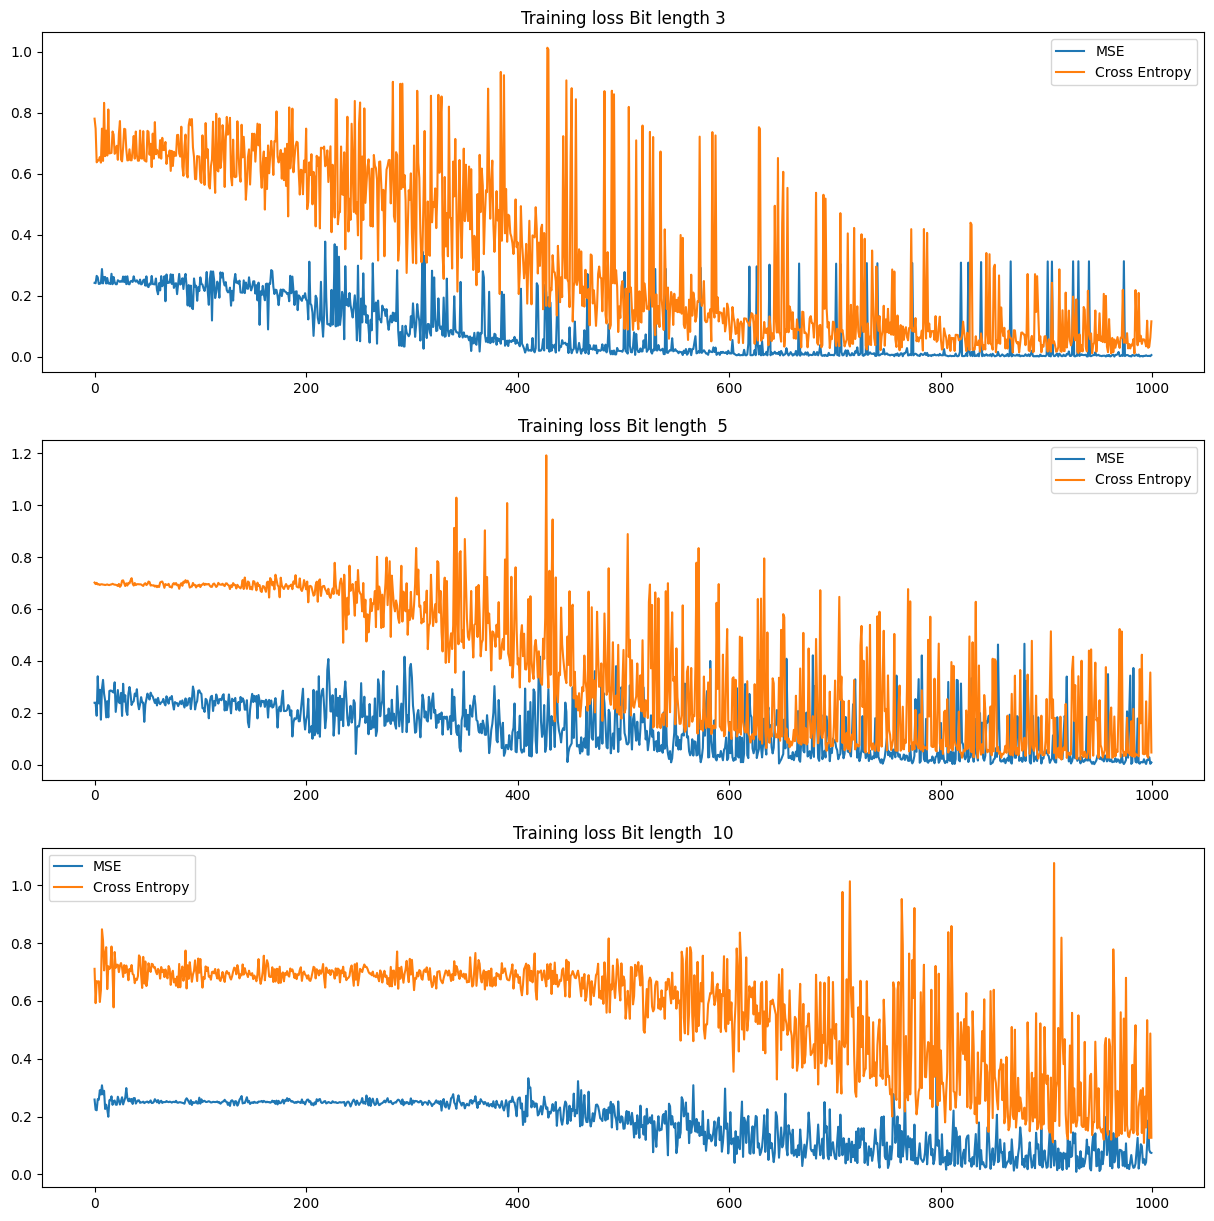

In [45]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))

model_3.plot(metric_bin_3["train_loss"],label = "MSE")
model_3.plot(metric_bin_3_ce["train_loss"],label = "Cross Entropy")
model_3.title.set_text("Training loss Bit length 3")
model_3.legend()

model_5.plot(metric_bin_5["train_loss"],label = "MSE")
model_5.plot(metric_bin_5_ce["train_loss"],label = "Cross Entropy")
model_5.legend()
model_5.title.set_text("Training loss Bit length  5")

model_10.plot(metric_bin_10["train_loss"],label = "MSE")
model_10.plot(metric_bin_10_ce["train_loss"],label = "Cross Entropy")
model_10.legend()
model_10.title.set_text("Training loss Bit length  10")

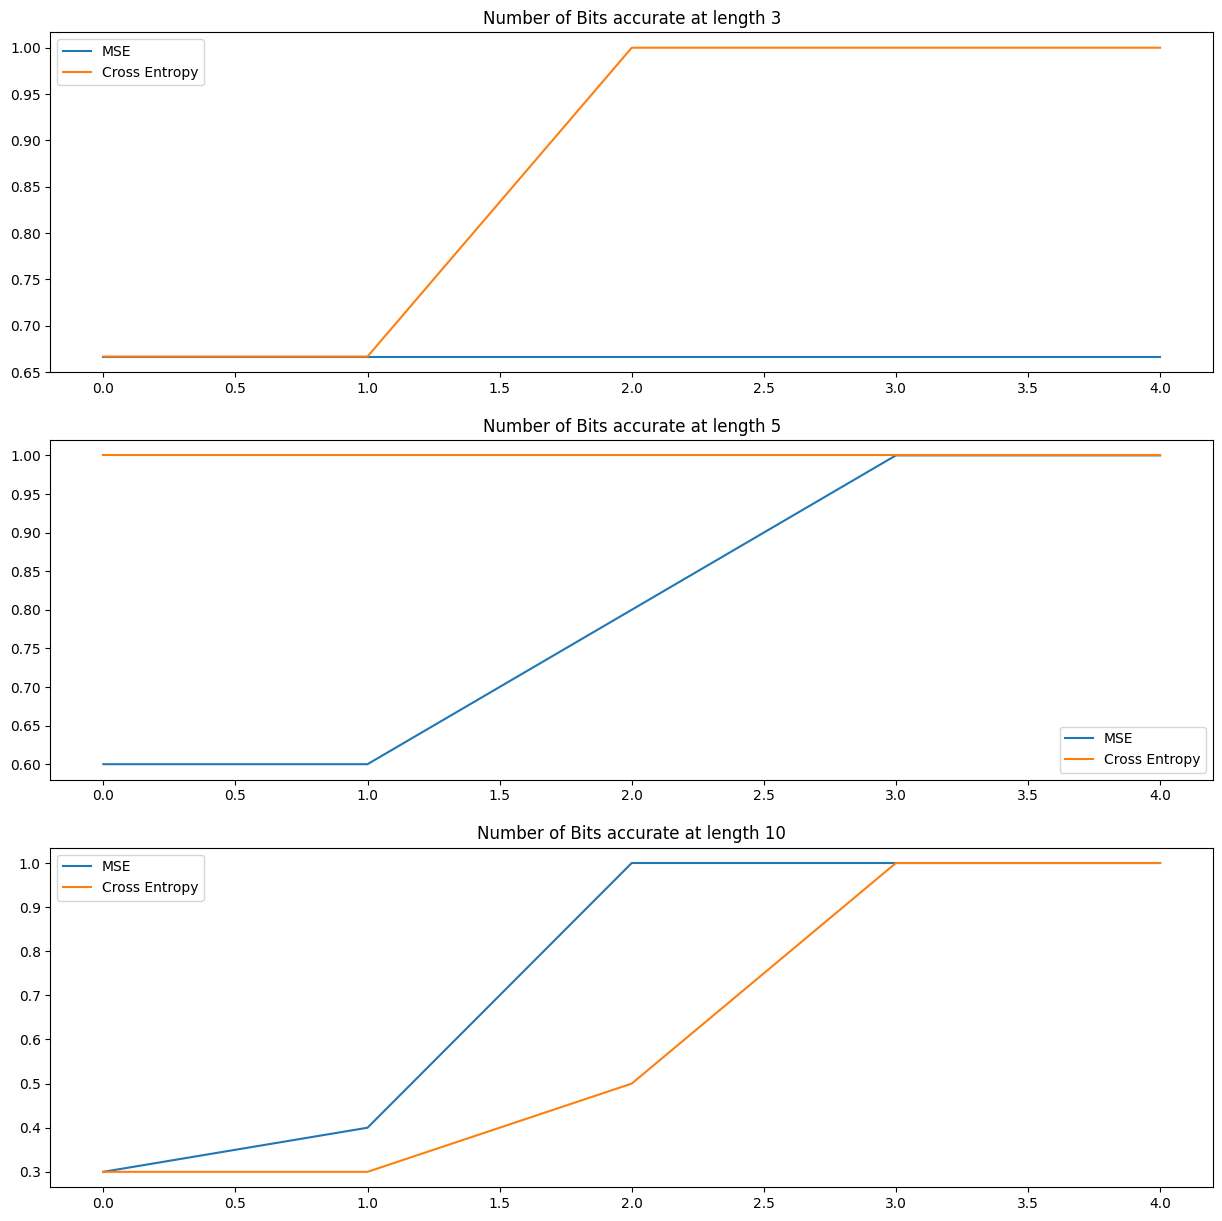

In [46]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))
model_3.plot(metric_bin_3["correct_test"],label = "MSE")
model_3.plot(metric_bin_3_ce["correct_test"],label = "Cross Entropy")
model_3.title.set_text("Number of Bits accurate at length 3")
model_3.legend()


model_5.plot(metric_bin_5["correct_test"],label = "MSE")
model_5.plot(metric_bin_5_ce["correct_test"],label = "Cross Entropy")
model_5.title.set_text("Number of Bits accurate at length 5")
model_5.legend()

model_10.plot(metric_bin_10["correct_test"],label = "MSE")
model_10.plot(metric_bin_10_ce["correct_test"],label = "Cross Entropy")
model_10.title.set_text("Number of Bits accurate at length 10")
model_10.legend()

In [47]:
model_bin_3_hid_5,metric_bin_3_hid_5 = train_bin_add(train_input = generate_data(size = train_size,l=3) ,
                                                     test_input = generate_data(size = test_size,l=3) ,
                                                     hidstate = 5)
model_bin_5_hid_5,metric_bin_5_hid_5 = train_bin_add(train_input = generate_data(size = train_size,l=5) ,
                                                     test_input = generate_data(size = test_size,l=5) ,
                                                     hidstate = 5)
model_bin_10_hid_5,metric_bin_10_hid_5 = train_bin_add(train_input = generate_data(size = train_size,l=10) ,
                                                       test_input = generate_data(size = test_size,l=10) ,
                                                       hidstate = 5)
print("With hidden size 5")


print(f"With size l = 3")
test_bin_add(model_bin_3_hid_5,test_data = generate_data(size = 20,l=3))
print(f"With size l = 5")
test_bin_add(model_bin_5_hid_5,test_data = generate_data(size = 20,l=5))
print(f"With size l = 10")
test_bin_add(model_bin_10_hid_5,test_data = generate_data(size = 20,l=10))

With hidden size 5
With size l = 3
Bit accuracy : 100.0 %
With size l = 5
Bit accuracy : 96.0 %
With size l = 10
Bit accuracy : 100.0 %


With cross entropy loss

In [48]:
model_bin_3_ce_hid_5,metric_bin_3_ce_hid_5 = train_bin_add_loss_cross_entropy(train_input = generate_data(size = train_size,l=3) ,
                                                                              test_input = generate_data(size = test_size,l=3) ,
                                                                              hidstate = 5)
model_bin_5_ce_hid_5,metric_bin_5_ce_hid_5 = train_bin_add_loss_cross_entropy(train_input = generate_data(size = train_size,l=5) ,
                                                                              test_input = generate_data(size = test_size,l=5) ,
                                                                              hidstate = 5)
model_bin_10_ce_hid_5,metric_bin_10_ce_hid_5 = train_bin_add_loss_cross_entropy(train_input = generate_data(size = train_size,l=10) ,
                                                                                test_input = generate_data(size = test_size,l=10) ,
                                                                                hidstate = 5)

print(f"With size l = 3")
test_bin_add(model_bin_3_ce_hid_5,test_data = generate_data(size = 20,l=3))
print(f"With size l = 5")
test_bin_add(model_bin_5_ce_hid_5,test_data = generate_data(size = 20,l=5))
print(f"With size l = 10")
test_bin_add(model_bin_10_ce_hid_5,test_data = generate_data(size = 20,l=10))

With size l = 3
Bit accuracy : 100.0 %
With size l = 5
Bit accuracy : 96.0 %
With size l = 10
Bit accuracy : 92.5 %


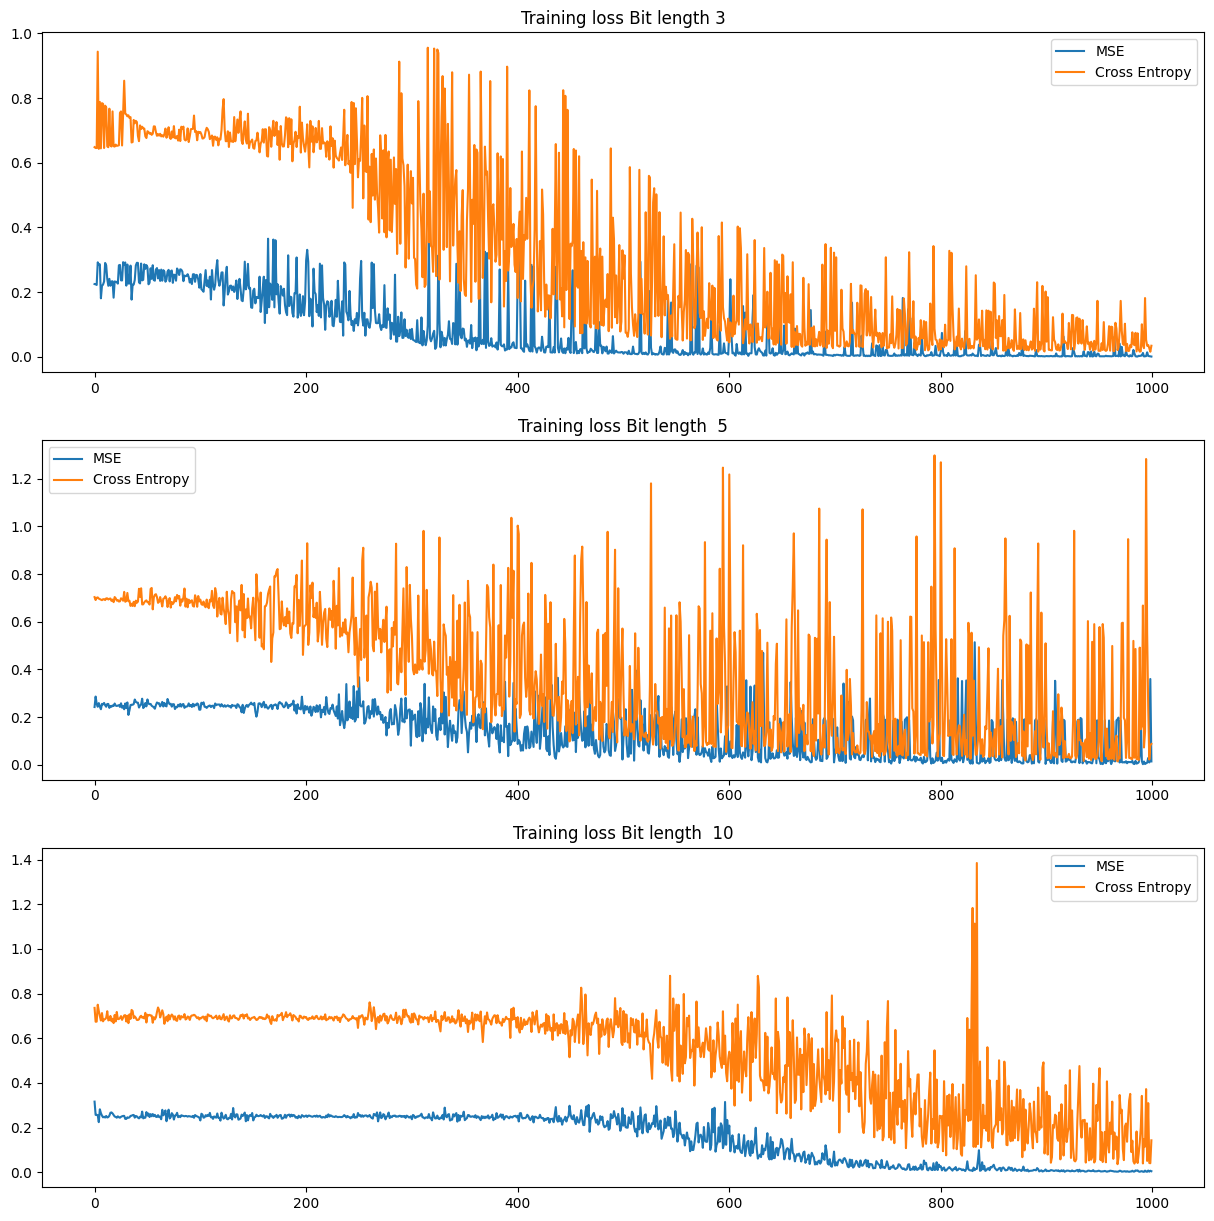

In [49]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))

model_3.plot(metric_bin_3_hid_5["train_loss"],label = "MSE")
model_3.plot(metric_bin_3_ce_hid_5["train_loss"],label = "Cross Entropy")
model_3.title.set_text("Training loss Bit length 3")
model_3.legend()

model_5.plot(metric_bin_5_hid_5["train_loss"],label = "MSE")
model_5.plot(metric_bin_5_ce_hid_5["train_loss"],label = "Cross Entropy")
model_5.legend()
model_5.title.set_text("Training loss Bit length  5")

model_10.plot(metric_bin_10_hid_5["train_loss"],label = "MSE")
model_10.plot(metric_bin_10_ce_hid_5["train_loss"],label = "Cross Entropy")
model_10.legend()
model_10.title.set_text("Training loss Bit length  10")

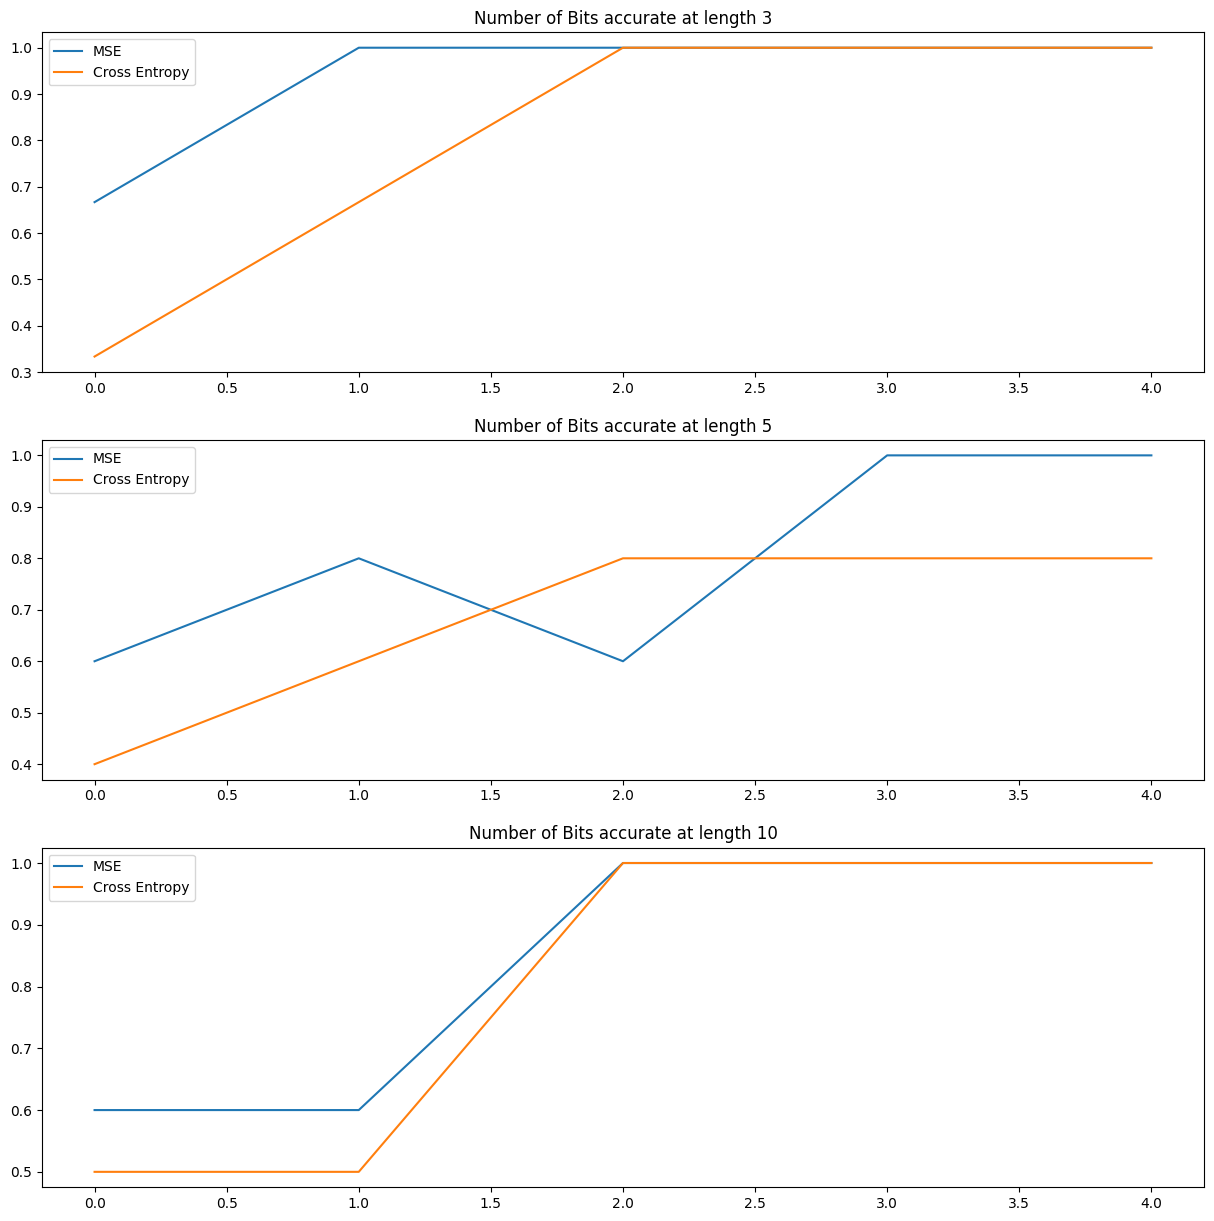

In [50]:
fig , (model_3,model_5,model_10) =  plt.subplots(3,1,figsize=(15, 15))
model_3.plot(metric_bin_3_hid_5["correct_test"],label = "MSE")
model_3.plot(metric_bin_3_ce_hid_5["correct_test"],label = "Cross Entropy")
model_3.title.set_text("Number of Bits accurate at length 3")
model_3.legend()


model_5.plot(metric_bin_5_hid_5["correct_test"],label = "MSE")
model_5.plot(metric_bin_5_ce_hid_5["correct_test"],label = "Cross Entropy")
model_5.title.set_text("Number of Bits accurate at length 5")
model_5.legend()

model_10.plot(metric_bin_10_hid_5["correct_test"],label = "MSE")
model_10.plot(metric_bin_10_ce_hid_5["correct_test"],label = "Cross Entropy")
model_10.title.set_text("Number of Bits accurate at length 10")
model_10.legend()